In [2]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Cargar y preparar los datos
data = pd.read_csv("C:\\Users\\lclai\\Desktop\\research LDIG\\data_dementia\\clean\\pitt_clean.csv")
data = data[(data['label'] == 0) | (data['label'] == 1)]

texts = data['clean_transcripts'].tolist()
labels = LabelEncoder().fit_transform(data['label'])

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

# Tokenizar
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(X_train, truncation=True, padding=True, return_tensors='tf', max_length=512)
test_encodings = tokenizer(X_test, truncation=True, padding=True, return_tensors='tf', max_length=512)

# Convertir a TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(8)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(8)

# Cargar modelo para clasificación (binaria → num_labels=2)
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Compilar el modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Entrenar
model.fit(train_dataset, epochs=3, validation_data=test_dataset)

# Evaluar
preds = model.predict(test_dataset).logits
predicted_labels = tf.argmax(preds, axis=1).numpy()

print(classification_report(y_test, predicted_labels))


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3

50/50 [==============================] - 761s 15s/step - loss: 0.6786 - accuracy: 0.5884 - val_loss: 0.6894 - val_accuracy: 0.5100
Epoch 2/3
50/50 [==============================] - 415s 8s/step - loss: 0.6358 - accuracy: 0.6237 - val_loss: 0.5149 - val_accuracy: 0.7300
Epoch 3/3
13/13 [==============================] - 37s 2s/step
              precision    recall  f1-score   support

           0       0.90      0.71      0.80        49
           1       0.77      0.92      0.84        51

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



In [3]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, predicted_labels))

0.8179271708683473


In [8]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import numpy as np
from sklearn.model_selection import train_test_split

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

data = pd.read_csv("C:\\Users\\lclai\\Desktop\\research LDIG\\data_dementia\\clean\\pitt_withoutwords.csv")
data = data[(data['label'] == 0) | (data['label'] == 1)].copy()

data['sex'] = data['sex'].map({"M": 0, "F": 1})


def get_bert_pooler_output(text, tokenizer, model, max_length=512):
    inputs = tokenizer(
        text,
        return_tensors="tf",
        padding='max_length',
        truncation=True,
        max_length=max_length
    )
    outputs = model(**inputs)
    return outputs.pooler_output 


pooler_outputs = []

for text in data['clean_transcripts']:
    pooled = get_bert_pooler_output(text, tokenizer, bert_model)
    pooler_outputs.append(pooled.numpy()[0])  

X_bert = np.array(pooler_outputs)


sex = data['sex'].values.reshape(-1, 1)
age = data['age'].values.reshape(-1, 1)
X = np.hstack((sex, age, X_bert))

X = pd.DataFrame(X, columns=['sex','age'] + [f"feature_{i}" for i in range(X.shape[1] - 2)])

y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X shape:", X.shape)
print("y shape:", y.shape)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

X shape: (496, 770)
y shape: (496,)


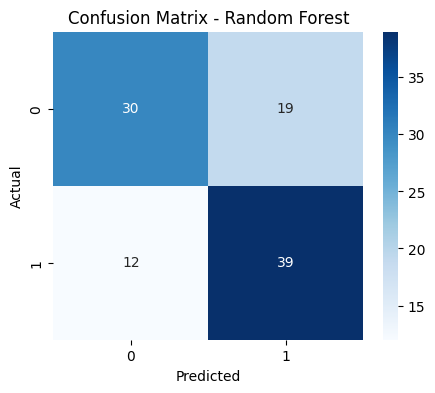

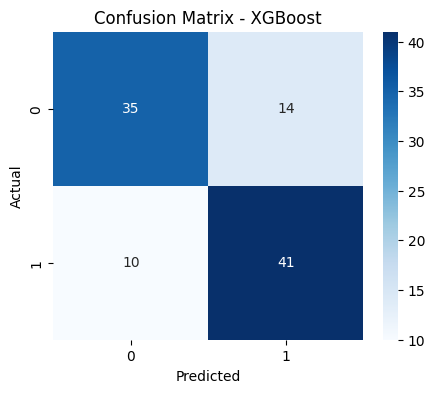

Model: Random Forest
Best Params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 500}
Mean AUC (CV=5): 0.7310
STD AUC (CV=5): 0.0544
AUC on Test Set: 0.7675

Model: XGBoost
Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 1000, 'model__subsample': 0.8}
Mean AUC (CV=5): 0.7662
STD AUC (CV=5): 0.0631
AUC on Test Set: 0.8539



In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


non_scaled_columns = ['sex']  # no escalar
scaled_columns = [col for col in X_train.columns if col not in non_scaled_columns]


preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), scaled_columns)
    ],
    remainder='passthrough'  
)


models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}


param_grids = {
    'Random Forest': {
        'model__n_estimators': [500, 1000],
        'model__max_depth': [None, 2,10],
        'model__min_samples_split': [2,5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'model__n_estimators': [500, 1000],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 6, 10],
        'model__subsample': [0.8, 1.0]
    }
}

results = {}

for model_name in models:
    model = models[model_name]
    param_grid = param_grids[model_name]

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    mean_auc_cv = grid_search.best_score_
    std_auc_cv = grid_search.cv_results_['std_test_score'][grid_search.best_index_]

    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, y_pred_proba)

    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        'best_params': grid_search.best_params_,
        'mean_auc_cv': mean_auc_cv,
        'std_cv': std_auc_cv,
        'auc_test': auc_test,
        'best_model': best_model
    }

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best Params: {result['best_params']}")
    print(f"Mean AUC (CV=5): {result['mean_auc_cv']:.4f}")
    print(f"STD AUC (CV=5): {result['std_cv']:.4f}")
    print(f"AUC on Test Set: {result['auc_test']:.4f}\n")


Mean AUC CV (XGBoost): 0.7804
Mean AUC CV (Random Forest): 0.7021
Mean AUC CV (Ensemble XGB+RF): 0.7686
Std AUC CV (Ensemble XGB+RF): 0.0368
AUC on Test Set (Ensemble XGB+RF): 0.8451


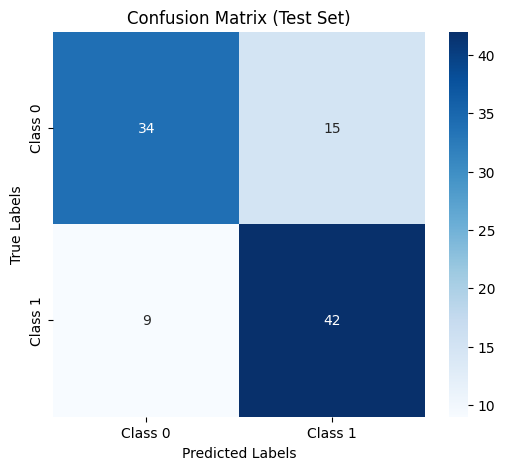

In [10]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

age_column = 'age'
sex_column = 'sex'
cols_to_scale = [col for col in X_train.columns if col not in [sex_column]]


xgb_clf = xgb.XGBClassifier(n_estimators=1000, max_depth=3, learning_rate=0.1, subsample=0.8, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_split=10, min_samples_leaf=2, max_features="sqrt", random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_xgb_folds = []
auc_rf_folds = []
auc_ensemble_folds = []

for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold = X_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_train_fold = y_train[train_idx]
    y_val_fold = y_train[val_idx]

    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), cols_to_scale)
        ],
        remainder='passthrough'
    )

    pipe_xgb = Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb.XGBClassifier(**xgb_clf.get_params()))
    ])

    pipe_rf = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(**rf_clf.get_params()))
    ])

    pipe_xgb.fit(X_train_fold, y_train_fold)
    pipe_rf.fit(X_train_fold, y_train_fold)

    pred_xgb = pipe_xgb.predict_proba(X_val_fold)[:, 1]
    pred_rf = pipe_rf.predict_proba(X_val_fold)[:, 1]
    pred_ensemble = (pred_xgb + pred_rf) / 2

    auc_xgb_folds.append(roc_auc_score(y_val_fold, pred_xgb))
    auc_rf_folds.append(roc_auc_score(y_val_fold, pred_rf))
    auc_ensemble_folds.append(roc_auc_score(y_val_fold, pred_ensemble))


final_preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), cols_to_scale)
    ],
    remainder='passthrough'
)

final_pipe_xgb = Pipeline([
    ('preprocessor', final_preprocessor),
    ('model', xgb_clf)
])

final_pipe_rf = Pipeline([
    ('preprocessor', final_preprocessor),
    ('model', rf_clf)
])

final_pipe_xgb.fit(X_train, y_train)
final_pipe_rf.fit(X_train, y_train)

pred_xgb = final_pipe_xgb.predict_proba(X_test)[:, 1]
pred_rf = final_pipe_rf.predict_proba(X_test)[:, 1]
pred_ensemble = (pred_xgb + pred_rf) / 2

auc_test = roc_auc_score(y_test, pred_ensemble)
y_pred_final = (pred_ensemble >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_final)


print(f"Mean AUC CV (XGBoost): {np.mean(auc_xgb_folds):.4f}")
print(f"Mean AUC CV (Random Forest): {np.mean(auc_rf_folds):.4f}")
print(f"Mean AUC CV (Ensemble XGB+RF): {np.mean(auc_ensemble_folds):.4f}")
print(f"Std AUC CV (Ensemble XGB+RF): {np.std(auc_ensemble_folds):.4f}")
print(f"AUC on Test Set (Ensemble XGB+RF): {auc_test:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import numpy as np

excluded_column = 'sex'
columns_to_scale = [col for col in X_train.columns if col != excluded_column]

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='auto', solver='lbfgs', random_state=42))
])


param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__max_iter': [100, 200, 500]
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor score (CV AUC): {grid_search.best_score_:.4f}")
print(f"STD AUC CV: {grid_search.cv_results_['std_test_score'][grid_search.best_index_]:.4f}")
print(f"AUC en Test Set: {auc:.4f}")


Mejores parámetros: {'classifier__C': 0.1, 'classifier__max_iter': 100}
Mejor score (CV AUC): 0.8234
STD AUC CV: 0.0742
AUC en Test Set: 0.9008
